# Spatial fMRI preprocessing
*If you haven't gone through the `09_fMRI_preprocessing1_temporal.ipynb` notebook, please do so first!*


This tutorial is based on the textbook here: https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/spatial_preprocessing.html

In the previous notebook, we've looked at how to temporally preprocess our signal through high-pass filtering, prewhitening, and nuisance regression. Importantly, these operations are *performed on the timeseries of each voxel separately*! Essentially, given our 4D fMRI data ($X \times Y \times Z \times T$), temporal filtering as we discussed here is only applied to the fourth dimension (the time-dimension, $T$).

In addition to these temporal operations, there are several spatial operations performed on (f)MRI data, including spatial smoothing (a form of filtering), distortion correction, and spatial registration/resampling, which are discussed in this notebook.

**What you'll learn**: after this lab, you'll ...

- explain the necessity of motion correction and the advantage of motion regression
- know how to implement the concepts above in Python


In [1]:
# import some functionality

import os
import pip
os.system('python -m pip install numpy')
os.system('python -m pip install matplotlib')
os.system('python -m pip install scipy')
os.system('python -m pip install nibabel')

import os.path as op
import numpy as np
from numpy.linalg import inv
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Spatial filtering (blurring/smoothing)
Spatial filtering refers to operations applied to the *spatial* dimensions ($X$, $Y$, and $Z$) of our 4D data. The most common spatial filtering operation &mdash; spatial smoothing &mdash; is usually implemented using a "3D gaussian (low-pass) smoothing kernel". Sounds familiar? Well, it should, because it's essentially the same type of filter as we used for our temporal high-pass filter! Only this time, it's not a 1-dimensional gaussian ("kernel") that does the high-pass filtering (i.e. allowing high-frequency signal to pass), but it's a 3-dimensional gaussian that does *low-pass* filtering (i.e. only keeping the low frequencies). Just like the temporal gaussian-weighted running line smoother is applied across time, we apply the 3D gaussian across space (i.e., the 3 spatial dimensions, $X$, $Y$, and $Z$). The figure below schematically visualized the process\*:

![](https://docs.google.com/drawings/d/e/2PACX-1vQZ8Eb8uNU9F0ZLLD1rRNwEE6zab8kVNFsUUZpDcPyDFWrfaPTSNB5otplVAuTV4lR0PhYWM-60_pMD/pub?w=850&h=421)

(Note that we show the spatial data in 2D, simply because it's easier to visualize, but in reality this is always 3D!)

In fact, because both (high-pass) temporal filtering and (low-pass) spatial filtering in most fMRI applications depend on the same "gaussian filtering" principle, we can even use the same Python function: `gaussian_filter`! However, as we mentioned before, spatial smoothing in fMRI is used as a *low-pass filter*, which means that the (spatial!) frequencies *higher* than a certain cutoff are filtered out, while the (spatial!) frequencies *lower* than this cut-off are *passed*. Therefore, we don't need to subtract the output from the `gaussian_filter` function from the (spatial) data! (If we'd would that, than we're effectively high-pass filtering the data!)

---
\* 3D gaussian figure from Philipp Klaus.

Before we go on and demonstrate smoothing on fMRI data, we need to determine the sigma of our (3D) gaussian kernel that we'll use to smooth the data. Annoyingly, smoothing kernels in the fMRI literature (and software packages!) are usually not reported in terms of sigma, but as "full-width half maximum" (FWHM), which refers to the width of the gaussian at half the maximum height:

![fwhm](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/FWHM.svg/1200px-FWHM.svg.png)

For example, you might read in papers something like "We smoothed our data with a gaussian kernel with a FWHM of 3 millimeter". So, we need to convert our desired FWHM (in millimeters) to sigma. In fact, this is the same conversion that we needed to do for our temporal Gaussian running line high-pass filter, but this time applied to the spatial domain (i.e., FWHM in mm) instead of the temporal domain (i.e., TR in seconds). We can use the same formula to convert FWHM (in mm.) to sigma: 

\begin{align}
\sigma_{kernel} = \frac{\mathrm{FWHM}_{mm}}{\sqrt{8 \ln{2}} \cdot \mathrm{voxel\ size}_{mm}}
\end{align}

So, for example, if I want to smooth at FWHM = 6 mm and my voxels are 3 mm in size (assuming equal size in the three spatial dimensions, which is common), my sigma becomes:

\begin{align}
\sigma_{kernel} = \frac{6}{\sqrt{8 \ln{2}} \cdot 3} \approx 0.85
\end{align}

The entire conversion process is a bit annoying, but it's simply necessary due to conventions in the fMRI literature/software packages.

Anyway, having dealt with the conversion issue, let's look at an example. We'll use the 4D fMRI data from before (the `data_4d` variable) and we'll extract a single 3D volume which we'll smooth using the `gaussian_filter` function. This particular data has a voxel-size of $6\ mm^{3}$; given that we want to smooth at an FWHM of, let's say, 10 millimeter, we need a sigma of $\frac{10}{\sqrt{8 \ln{2}} \cdot 6} \approx 0.7$.

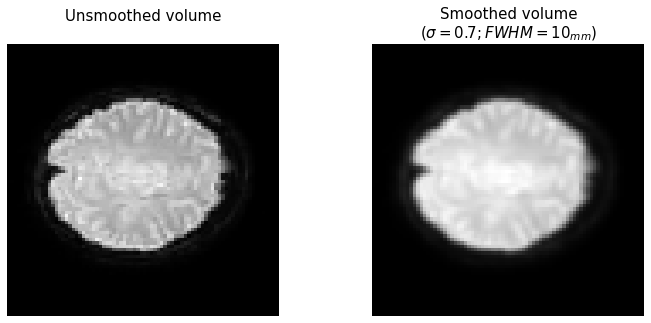

In [2]:
#Let's load the data that we have been using before
data_4d = nib.load('data/func.nii.gz').get_fdata()
vol = data_4d[:, :, :, 20] # We'll pick the 21st volume (Python is 0-indexed, remember?)

fwhm = 10
voxelsize = 6

sigma = fwhm / (np.sqrt(8 * np.log(2)) * voxelsize)
smoothed_vol = gaussian_filter(vol, sigma=sigma)

# Let's plot both the unsmoothed and smoothed volume
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(vol[:, :, 30], cmap='gray') # And we'll pick the 11th axial slice to visualize
plt.axis('off')
plt.title("Unsmoothed volume\n", fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(smoothed_vol[:, :, 30], cmap='gray')
plt.axis('off')
plt.title('Smoothed volume\n($\sigma = %.1f; FWHM = %s_{mm}$)' % (sigma, fwhm), fontsize=15)
plt.show()

Now, in the above example we only smoothed a single volume, but in your analyses you would of course <b>smooth all volumes</b> in your fMRI run! (Just like with temporal filtering you need to filter the timeseries of all voxels separately.) Next, we need to loop through all (50) volumes from the <tt>data_4d</tt> variable and smooth them separately. We'll store the smoothed data in the already pre-allocated variable <tt>data_4d_smoothed</tt>. We'll use a sigma of 0.7 for the gaussian filter.


In [3]:


data_4d_smoothed = np.zeros(data_4d.shape)

for i in range(data_4d.shape[-1]):
    data_4d_smoothed[:, :, :, i] = gaussian_filter(data_4d[:, :, :, i], sigma=0.7)


<div class='alert alert-info'>
    <b>ToThink1</b>: Since the <tt>gaussian_filter</tt> works for any $N$-dimensional array, one could argue that you don't have to loop through all volumes and apply a 3D filter, but you could equally well skip the loop and use a 4D filter straightaway. Explain (concisely) why this is a bad idea (for fMRI data). (Solution at the end of the notebook)
</div>

Write your answer to the ToThink1 question here:

## Susceptibility distortion correction (SDC)
Most functional MRI sequences use a technique called "gradient-echo echo planar imaging" (GE-EPI), which is a relatively sensitive and well-established technique for BOLD-MRI. For reasons beyond the scope of these tutorials, GE-EPI scans unfortunately show signs of **"geometric distortion"** (sometimes called susceptibility distortion) and **signal loss** in some areas of the brain. Signal loss, which is most apparent in areas with B0 (static magnetic field) inhomogeneities caused by sudden air-tissue transitions (like around the ears, earduct &rarr; brain, and the ventromedial cortex, frontal sinus &rarr; brain). Geometric distortion is most visible in the phase-encoding direction of the scan (usually posterior &rarr; anterior or left &rarr; right). These geometric distorions are usually visible as tissue "folding" inwards or outwards (depending on the exact phase-encoding direction, e.g., posterior &rarr; anterior or anterior &rarr; posterior). 

In the gif below, you can see where signal loss (in ventromedial cortex and around the ears, best visible in slice `z=12`) and geometric distortion is most apparent. The "before" image is the one *with* geometric distortion (most apparent as folding inwards of the cerebellum and frontal cortex). Hover your cursor above the image to see it changing from uncorrected ("before") to corrected ("after").

![SegmentLocal](images/sdc.gif "segment")

While there is (currently) no way to correct for signal loss, there *are* ways to correct for geometric distortion (as you can see in the gif above). Most distortion correction techniques require you to acquire additional scans that can be used to correct (or "unwarp") your functional MRI scans. One technique is to acquire a "fieldmap" scan to image the homogeneity of the magnetic field (based on two scans with slightly different TEs) which can then be used for geometric correction. Another technique, often called "topup unwarping" (or PEPOLAR unwarping), uses one or more volumes of a separate functional MRI scan with the opposite phase-encoding direction as your to-be-correction functional MRI scan. In the "topup" scan, the distortion is expected to be in the complete opposite direction as in your to-be-correction fMRI scan (e.g., inward folding of tissue where the fMRI scan would show outward folding and vice versa), which can then be used to estimate an undistorted shape (which is "in the middle" of the fMRI and topup scan). 

The mathematics and implementation of distortion correction is beyond the scope of this course, but we just wanted it to show you so that you're familiar with the term!

## Motion correction / realignment
Participant movement during scanning arguably affects your data quality most, and should be taken care of accordingly. As such, *motion correction* (or sometimes called *motion realignment*) is an important step in any preprocessing pipeline. Motion correction makes sure that all volumes (i.e., 3D fMRI images) are spatially aligned. Before discussing motion correction in more detail, let's take a look at how a motion corrupted scan looks like. Actually, the data that we've been using so far (`data_4d`) actually has very little motion, so we're going to add some motion to it (with a custom function `add_motion_to_vols`). The functions below implement the motion:

In [17]:
from scipy.ndimage import affine_transform
from time import sleep
from IPython.display import clear_output

def add_motion_to_vols(vols):
    
    new_vols = np.zeros_like(vols)
    for i in range(new_vols.shape[-1]):
        rot = np.random.uniform(-2, 2, 3)
        trans = np.random.uniform(-0.1, 0.1, 3)
        rot_mat = get_rotation_matrix(*rot)
        trans_mat = get_translation_matrix(*trans)
        center = np.eye(4)
        center[:, -1] = np.r_[np.array(vols.shape[:3]) // 2 - 0.5, 1]
        affine = trans_mat @ center @ rot_mat @ inv(center)
        new_vols[:, :, :, i] = affine_transform(vols[:, :, :, i], matrix=inv(affine))
    return new_vols


def animate_volumes(vols, idx=25, axis=2, show_until=None, to_sleep=0.5, **kwargs):
    if show_until is None:
        show_until = vols.shape[-1]
    
    vols = np.take(vols, idx, axis)
    for i in range(show_until):
        plt.figure(figsize=(8, 8))
        plt.imshow(vols[:, :, i], cmap='gray', **kwargs)
        plt.title("Volume nr. %i" % i, fontsize=(25))
        plt.axis('off')
        plt.show()
        sleep(to_sleep)
        clear_output(wait=True)
        
def get_rotation_matrix(x=0, y=0, z=0):
    """ Computes the rotation matrix.
    
    Parameters
    ----------
    x : float
        Rotation in the x (first) dimension in degrees
    y : float
        Rotation in the y (second) dimension in degrees
    z : float
        Rotation in the z (third) dimension in degrees
    
    Returns
    -------
    rot_mat : numpy ndarray
        Numpy array of shape 4 x 4
    """
    
    x = np.deg2rad(x)
    y = np.deg2rad(y)
    z = np.deg2rad(z)
    
    rot_roll = np.array([
        [1, 0, 0, 0],
        [0, np.cos(x), -np.sin(x), 0],
        [0, np.sin(x), np.cos(x), 0],
        [0, 0, 0, 1]
    ])

    rot_pitch = np.array([
        [np.cos(y), 0, np.sin(y), 0],
        [0, 1, 0, 0],
        [-np.sin(y), 0, np.cos(y), 0],
        [0, 0, 0, 1]
    ])

    rot_yaw = np.array([
        [np.cos(z), -np.sin(z), 0, 0],
        [np.sin(z), np.cos(z), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    rot_mat = rot_roll @ rot_pitch @ rot_yaw
    return rot_mat


def get_translation_matrix(x=0, y=0, z=0):
    
    """ Computes the translation matrix.
    
    Parameters
    ----------
    x : float
        Translation in the x (first) dimension in voxels
    y : float
        Rotation in the y (second) dimension in voxels
    z : float
        Rotation in the z (third) dimension in voxels
    
    Returns
    -------
    trans_mat : numpy ndarray
        Numpy array of shape 4 x 4
    """
    
    trans_mat = np.eye(4)
    trans_mat[:, -1] = [x, y, z, 1]
    return trans_mat



Then, we'll plot it volume by volume as a short movie.

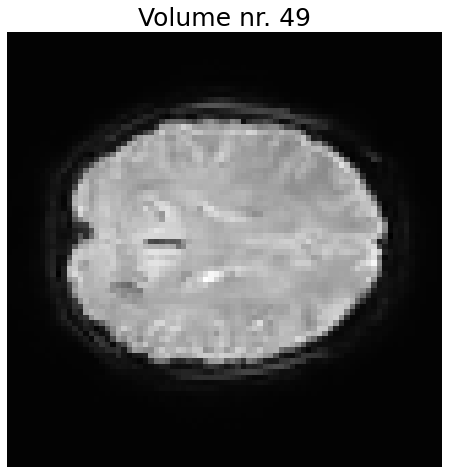

In [18]:

vols = add_motion_to_vols(data_4d)
animate_volumes(vols)

### Rigid body registration
Motion correction aligns all volumes by picking a reference volume (usually the first or middle one) and subsequently "moving" all the other volumes such that they are spatially aligned with the reference volume. Specifically, motion correction uses *translation* (movement along the primary axes: left/right, up/down, front/back) and *rotation* (around the center of the image).

![pitchrollyaw](https://www.researchgate.net/profile/Tsang_Ing_Ren/publication/279291928/figure/fig1/AS:292533185462272@1446756754388/Orientation-of-the-head-in-terms-of-pitch-roll-and-yaw-movements-describing-the-three.png)
*Image from [Arcoverde Neto et al. (2014)](https://www.researchgate.net/figure/Orientation-of-the-head-in-terms-of-pitch-roll-and-yaw-movements-describing-the-three_fig1_279291928).*

This specific transformation of the image has six parameters (translation in the X, Y, and Z direction, and rotation in the X, Y, and Z direction) and is often called a "rigid body registration". Given these parameters, the to-be-moved volume can be spatially resampled at the location of the reference volume.

A rigid body registration is an example of a more general *affine registration*: a linear transformation of an image that may involve translation, rotation, scaling, and shearing. For motion correction, scaling and shearing is *not* applied.

<div class='alert alert-info'>
    <b>ToThink2</b>: Why do you think motion correction not use scaling and shearing transformations?
</div>

Write yor answer to the ToThink2 question here:

### Affine registrations
For affine registrations, the way the image should be moved is defined in the affine matrix, a $4 \times 4$ matrix. This matrix is similar to the one we discussed in week 1, but instead of describing how each image coordinate ($i, j, k$) relates to world coordinates ($x, y, z$), the affine matrix, here, describes how the coordinates from the original (non-corrected) image related to the corrected image:

\begin{align}
\begin{bmatrix} i_{corr}, j_{corr}, k_{corr}, 1 \end{bmatrix} = A\begin{bmatrix}
           i \\
           j \\
           k \\
           1
         \end{bmatrix}
\end{align}

For example, suppose I have a particular affine matrix (`A_example`, below) that encodes a translation of 3 voxels downwards (superior &rarr; inferior). Then, for any coordinate $(x, y, z, 1)$, I can compute the location of the coordinate in the corrected image as follows:

In [19]:
A_example = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 3],
    [0, 0, 0, 1]
])

# Note that we always have to append a 1, just like in the previous tutorial
coord = np.array([0, 0, 0, 1])  # the middle of the image!
corr_coord = A_example @ coord
print(corr_coord[:3])

[0 0 3]


As expected, the affine transformation above shows us that the middle coordinate $(0, 0, 0)$ refers to the corrected coordinate $(0, 0, 3)$ after translating the image 3 voxels downwards. But how is this particular translation encoded in the affine? For translation, this is relatively straightforward. For any translation $(x, y, z)$, the affine matrix looks like:

\begin{align}
\begin{bmatrix} i_{\mathrm{trans}} & j_{\mathrm{trans}} & k_{\mathrm{trans}} & 1 \end{bmatrix} =
\begin{bmatrix}
           1 & 0 & 0 & x \\
           0 & 1 & 0 & y \\
           0 & 0 & 1 & z \\
           0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
           i \\
           j \\
           k \\
           1
         \end{bmatrix}
\end{align}

For rotation, however, it is slightly more complicated! For rotation transformations (with rotations $x, y, z$ in radians), the affine is computed by the matrix 

\begin{align}
\begin{bmatrix} i_{\mathrm{rot}} & j_{\mathrm{rot}} & k_{\mathrm{rot}} & 1 \end{bmatrix} =
    \begin{bmatrix}
           1 & 0 & 0 & 0 \\
           0 & \cos(x) & -\sin(x) & 0 \\
           0 & \sin(x) & \cos(x) & 0 \\
           0 & 0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
           \cos(y) & 0 & \sin(y) & 0 \\
           0 & 1 & 0 & 0 \\
           -\sin(y) & 0 & \cos(y) & 0 \\
           0 & 0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
           \cos(z) & -\sin(z) & 0 & 0 \\
           \sin(z) & \cos(z) & 0 & 0 \\
           0 & 0 & 1 & 0 \\
           0 & 0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    i \\
    j \\
    k \\
    1
    \end{bmatrix}
\end{align}

As you can see, rotations are actually encoded in the affine matrix as the result of matrix multiplication of the the separate x, y, and z rotation matrices. Don't worry, you don't have to program this rotation-to-affine operation. Using a custom function (`get_rotation_matrix`), implemented above, let's take a look at what the affine matrix would look like for a rotation of 45 degrees in all three directions:

In [20]:
       
A_rot = get_rotation_matrix(x=45, y=45, z=45)
print(A_rot)

[[ 0.5        -0.5         0.70710678  0.        ]
 [ 0.85355339  0.14644661 -0.5         0.        ]
 [ 0.14644661  0.85355339  0.5         0.        ]
 [ 0.          0.          0.          1.        ]]


Now, if we want to combine both rotations and translations, we multiply the translation matrix ($T$) with our rotation matrix ($R = R_{x}R_{y}R_{z}$):

\begin{align}
A = TR
\end{align}

<b>Example</b>. Above, we also defined a function to get the translation matrix. Now, suppose I want to rotate my image with 45 degrees in the z-direction and translate my image with 10 voxels in the x-direction and 5 voxels in the y-direction. We'll calculate the corresponding affine matrix, and store this in a variable named <tt>affine_ex</tt>.
</div>

In [21]:

trans_mat = get_translation_matrix(10, 5, 0)
rot_mat = get_rotation_matrix(0, 0, 45)
affine_ex = trans_mat @ rot_mat
print(affine_ex)

[[ 0.70710678 -0.70710678  0.         10.        ]
 [ 0.70710678  0.70710678  0.          5.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


Now, we're not going to discuss the intricacies of how to actually resample an image given a particular affine. Instead, we defined a function called `resample_image` that resamples an image given a particular translation and rotation matrix. It's a bit more complicated than we discussed so far, but you get the idea.

In [23]:
from scipy.ndimage import affine_transform

def resample_image(image, trans_mat, rot_mat):
    """ Resamples an image given a translation and rotation matrix.
    
    Parameters
    ----------
    image : numpy array
        A 3D numpy array with image data
    trans_mat : numpy array
        A numpy array of shape 4 x 4
    rot_mat : numpy array
        A numpy array of shape 4 x 4
    
    Returns
    -------
    image_reg : numpy array
        A transformed 3D numpy array
    """
    
    # We need to rotate around the origin, not (0, 0), so
    # add a "center" translation
    center = np.eye(4)
    center[:3, -1] = np.array(image.shape) // 2 - 0.5
    A = center @ trans_mat @ rot_mat @ np.linalg.inv(center)
    
    # affine_transform does "pull" resampling by default, so
    # we need the inverse of A
    image_corr = affine_transform(image, matrix=np.linalg.inv(A))
    
    return image_corr

<div class='alert alert-warning'>
    <b>ToDo</b>: Try out different transformations of an actual brain image by changing the arguments given to <tt>get_translation_matrix</tt> and <tt>get_rotation_matrix</tt>. You can also change the axis (<tt>PLOT_AXIS</tt>) and slice number (<tt>SLICE_IDX</tt>) that is plotted.
</div>

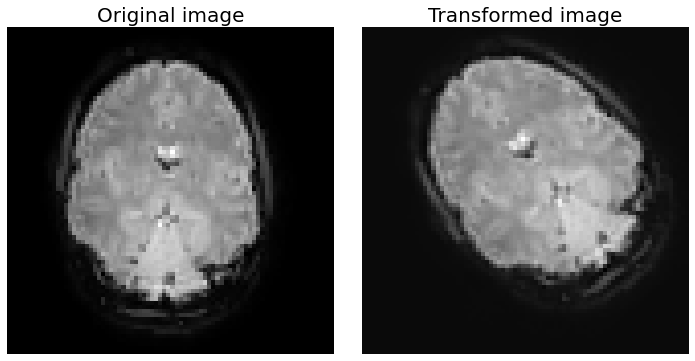

In [24]:
trans_mat = get_translation_matrix(5, 5, 0)
rot_mat = get_rotation_matrix(0, 0, 40)

vols = data_4d
VOL = vols[:, :, :, 0]
PLOT_AXIS = 2
SLICE_IDX = 20

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.take(VOL, SLICE_IDX, PLOT_AXIS).T, origin='lower', cmap='gray')
plt.axis('off')
plt.title('Original image', fontsize=20)

# Resample
vol_res = resample_image(VOL, trans_mat, rot_mat)

plt.subplot(1, 2, 2)
plt.imshow(np.take(vol_res, SLICE_IDX, PLOT_AXIS).T, origin='lower', cmap='gray')
plt.axis('off')
plt.title('Transformed image', fontsize=20)

plt.tight_layout()
plt.show()

Now, suppose that we want to align two volumes with each other. How would we go about it? Visually, it's quite hard to assess whether a particular affine matrix works well. In practice, most neuroimaging software packages use automatic algorithms that try to find a affine matrix that *minimizes some cost function*. In other words, it defines a function to evaluate the mismatch (or cost) of the alignment of two volumes given an affine matrix, and then it tries to minimize this function by (in a smart way) trying out different rotation and translation parameters.

One cost function that is often used for rigid body registration is "least squares", which is defined as the sum over the squared (voxel-wise, $v$) differences between the reference image (sometimes called the "fixed" image) and the realigned image (sometimes called the "moving" image):

\begin{align}
\mathrm{cost}_{LS} = \sum_{v}(\mathrm{fixed}_{v} - \mathrm{moving}_{v})^2
\end{align}

We'll define a function named <tt>least_squares_cost</tt> below, that takes two input parameters &mdash; <tt>fixed</tt> and <tt>moving</tt> (both 3D numpy arrays) &mdash; and outputs the least-squares cost.


In [46]:

def least_squares_cost(fixed, moving):
    return np.sum((fixed - moving)** 2)


<div class='alert alert-warning'>
    <b>ToDo1</b> : For this ToDo, <em>you</em> are going to be the optimizer! Below, we have loaded two (brain) images: <tt>fixed</tt> and <tt>moving</tt>. Use the <tt>resample_image</tt> function to translate/rotate the <tt>moving</tt> image. We'll name the output (i.e., the transformed volume) <tt>moved</tt>. This is then plotted on top of the reference volume together with the cost to give you an idea of how well your transformation worked. Keep doing this until you're satisfied.
    
Hint 1: you need rotation in the z dimension and translation in the x and y dimension.<br>
Hint 2: rotation is counter clockwise (if you define negative rotation, e.g. -20, it will be rotated clockwise).

(See end of the notebook for solution)
</div>

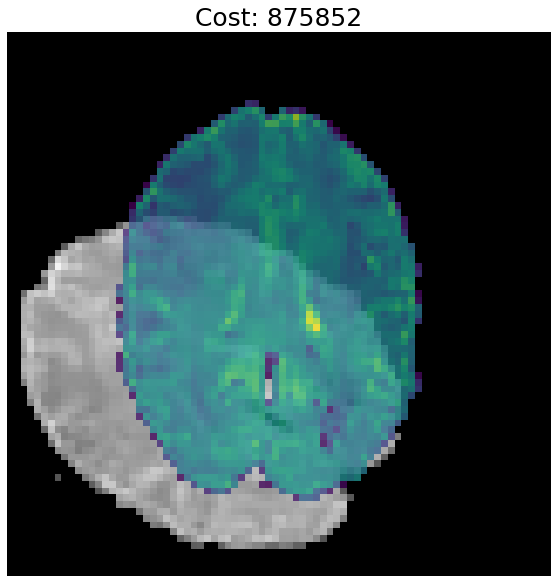

In [56]:
with np.load('data/moco_todo.npz') as moco_data:
    moving = moco_data['moving']
    fixed = moco_data['fixed']

#Work on the rotation and translation parameters to minimize difference (i.e. cost)
moved = resample_image(
    moving,
    rot_mat=get_rotation_matrix(0, 0, 0),
    trans_mat=get_translation_matrix(0, 0, 0)
)
cost = least_squares_cost(fixed, moved)


### Plotting starts here

plt.figure(figsize=(10, 10))
plt.imshow(fixed[:, :, 25].T, origin='lower', cmap='gray')
moved4plot = np.ma.masked_where(moved < 2, moved)
plt.imshow(moved4plot[:, :, 25].T, origin='lower', alpha=0.8)
plt.title("Cost: %i" % cost, fontsize=(25))
plt.axis('off')
plt.show()

## Anatomical realignment/registration and normalization
So far, we discussed how to register volumes to a reference volume using rigid body registrations (with a six parameter affine) in the context of motion correction. This is, however, only the first step in the complete registration protocol of (most) studies. If your goal is, in the end, to perform some kind of group analysis (in which you pool together data from multiple subjects), you want to make sure that each voxel (at location $(X, Y, Z)$) is in (roughly) the same location in the brain. The problem is that people's brains differ quite a bit in terms of anatomy! Therefore, you need to register (transform) your subject-level (functional) data to some kind of common template. This process is often done in two stages: first, you compute a registration from (a reference volume of) your functional data ("moving") to your anatomical data (your high-resolution T1-weighted scan; "fixed"), and second you compute a registration from your anatomical data ("moving") to a common template ("fixed"). Then, you can register your functional data to the common template by sequentially applying the first and second stage registration parameters. This is visualized in the figure below.

![reg](https://docs.google.com/drawings/d/e/2PACX-1vQEpo53zns0VHAgEBkEU9lqQ58RnqINqdUpdLDX-5X9pjLk_BNghfuPBp9zu2nRNzgVQBJZ4GuX5ejz/pub?w=1698&h=516)

In the figure above, you can see that the first stage (BOLD &rarr; T1w) uses the same registration protocol as we used with motion-correction: an affine transformation with 6 parameters (translation and rotation in 3 directions; a "rigid body registration"). The second stage (T1w &rarr; template) also uses an affine transformation, but this time with 12 parameters. In addition to the 6 rigid body registration parameters, a 12 parameter affine (sometimes reffered to as an affine with 12 degrees-of-freedom, DOF) also includes global scaling in 3 directions (i.e., making the brain bigger of smaller) and shearing in 3 directions (i.e., "stretching" in 3 directions). These extra parameters attempt to overcome the anatomical differences between the individual subjects' brains and the template. 

However, only a 12 DOF affine is usually not sufficient for proper alignment. Therfore, most neuroimaging software packages also offer the option to apply a non-linear registration step ("warping") *on top of the 12 DOF affine registration*. Instead of globally transforming your "moving" volume (i.e., the transformation applies to each voxel equally), non-linear registrations allow for *local* transformations (i.e., some voxels might be transformed "more" than others). Usually, the combination of an initial 12 DOF affine and a non-linear ("warping") registration operation lead to a proper alignment of the subject's anatomical volume and the template.

When we discussed motion correction, we used the "least squares" cost function to optimize our rigid body registration parameters. 

This is not a good idea for the BOLD &rarr; T1w registration, because the tissue contrasts are opposite: in BOLD, CSF is the brightest (i.e., has large signal intensity), gray matter is also (relatively) bright, while white matter is (relatively) dark; for T1-weighted scans, it is the exact opposite (i.e., CSF is dark, gray matter is a little brighter, and white matter is the brightest - see figure above). Using a least squares cost function would unduly penalize properly aligned volumes just because the contrasts are different.

Instead, other cost functions can be applied (e.g. maximizing [mutual information](https://en.wikipedia.org/wiki/Mutual_information)). But this is beyond the present tutorial.

For T1w &rarr; template registrations, you actually *can* use the least squares cost function, because they are from the same modality: they're both T1-weighted scans. You can see this in the image above (in the template brain, white matter is brightest, followed by gray matter, and is darkest in CSF).
</div>

## Motion filtering
Even after motion realignment, your data is still 'contaminated' by motion. This is because movement itself influences the measured activity. For example, suppose that you measure a single voxel in someone's brain; then, this person moves his/her head 2 centimeters. Now, we can do motion realigment to make sure we measure the same voxel before and after the movement, but *this does not change the fact that this particular voxel was originally measured at two different locations*. It could be that after the movement, the voxel was actually a little bit closer to the headcoil, which results in a (slight) increase in signal compared to before the movement (this is also known as "spin history effects").

Ideally, you want to account for these interactions between motion and the measured activity. One way to do this is through "motion filtering", of which one popular approach is to simply add the 6 realignment parameters (rotation and translation in 3 directions) to the design-matrix ($X$)! In other words, we treat the motion realignment parameters as "nuisance regressors" that are aimed to explain activity that is related to motion. Realize that this is, thus, as temporal preprocessing step (which we discuss here instead of the previous notebook because we needed to explain motion correction first).

Alright, let's load some realigment parameters (6 in total) from an fMRI run of 200 volumes. We'll plot them below:

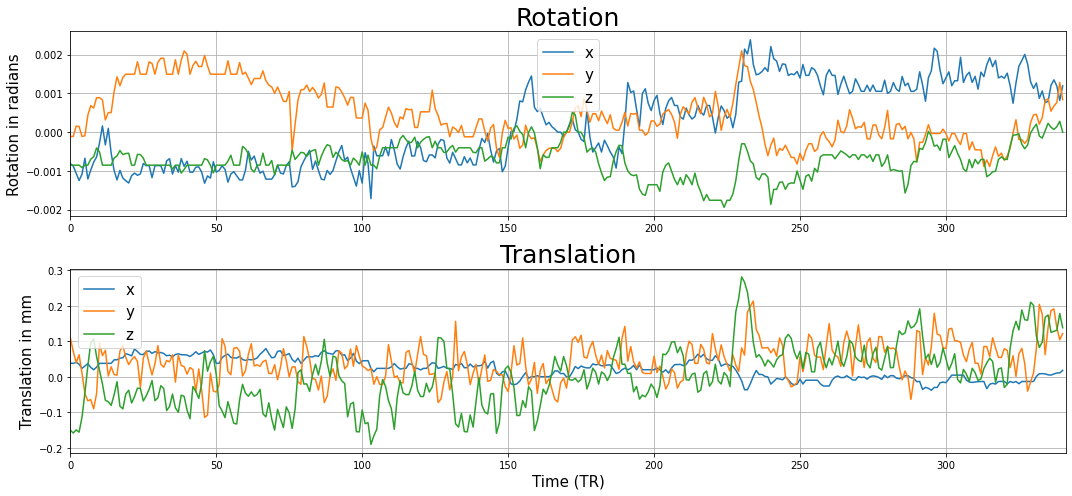

In [58]:
""" This data has been motion-corrected using the FSL tool 'MCFLIRT', which outputs a file
ending in *.par that contains the 6 motion parameters (rotation/translation in 3 directions each).
We'll load in this file and plot these motion parameters. """

motion_params = np.loadtxt('data/func_motion_pars_new.txt')
rotation_params = motion_params[:, :3]
translation_params = motion_params[:, 3:]

plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.title('Rotation', fontsize=25)
plt.plot(rotation_params)
plt.xlim(0, motion_params.shape[0])
plt.legend(['x', 'y', 'z'], fontsize=15)
plt.ylabel('Rotation in radians', fontsize=15)
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Translation', fontsize=25)
plt.plot(translation_params)
plt.legend(['x', 'y', 'z'], fontsize=15)
plt.ylabel('Translation in mm', fontsize=15)
plt.xlim(0, motion_params.shape[0])
plt.xlabel('Time (TR)', fontsize=15)
plt.grid()

plt.tight_layout()
plt.show()

So, is this good data or not? In general, you could say that higher values (in either translation or rotation) are worse. That said, from the translation and rotation parameters alone it is hard to judge whether the participant moved *too* much, partly because we're dealing with 6 parameter traces here. One way to make this decision process a little easier is to convert these parameters to a single "framewise displacement" (FD) trace. FD aims to represent "bulk motion" and is a summary statistic of motion that combines all motion parameters into a single metric. It is calculated as follows:

\begin{align}
FD_{t} = |r(\mathrm{rot}_{tx} - \mathrm{rot}_{(t-1)x})| + |r(\mathrm{rot}_{ty} - \mathrm{rot}_{(t-1)y})| + |r(\mathrm{rot}_{tz} - \mathrm{rot}_{(t-1)z})| + |\mathrm{trans}_{xt} - \mathrm{trans}_{x(t-1)}| + |\mathrm{trans}_{yt} - \mathrm{trans}_{y(t-1)}| + |\mathrm{trans}_{zt} - \mathrm{trans}_{z(t-1)}|
\end{align}

where $|x|$ means the absolute value of $x$ and $r$ stands for a predefined radius in millimeters (which is usually taken to be 50). So, basically it is a sum across the absolute successive differences ($x_{t} - x_{t-1}$) of parameter traces.

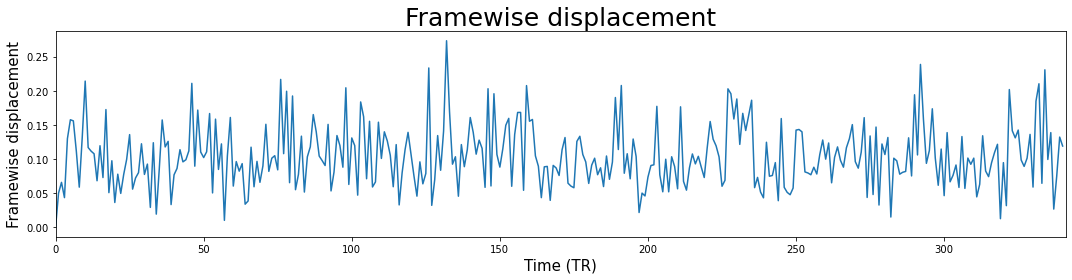

In [59]:
#We will assume a radius of 50
r = 50
#subtract the motion params from the params at lag1
diff = motion_params[:-1, :6] - motion_params[1:, :6]
#Scale the rotations with the radius
diff[:, :3] *= r
#sum absolute difference across all dimensions
fd_trace = np.abs(diff).sum(axis=1)
#insert a value at index 0, given that the first value is undefined (because at t=0 there is no t-1 to subtract)
fd_trace = np.insert(fd_trace, 0, 0)

plt.figure(figsize=(15, 4))

plt.title('Framewise displacement', fontsize=25)
plt.plot(fd_trace)
plt.xlim(0, motion_params.shape[0])
plt.ylabel('Framewise displacement', fontsize=15)
plt.xlabel('Time (TR)', fontsize=15)


plt.tight_layout()
plt.show()

As said in the beginning of this section, motion parameters (translation/rotation in 3 dimensions) are used as nuisance regressors in subject-level analyses. The reason for this is that, even after motion correction, the actual movement may have influenced the signal intensity through "spin-history effects", which occurs when a voxel is excited by an RF pulse slightly earlier/later due to movement (i.e., it may have moved up or down one slice), which changes how much T1 relaxation occurs (which affect the signal intensity; read more [here](http://imaging.mrc-cbu.cam.ac.uk/imaging/CommonArtefacts)).

There are two ways to go about this, which are not mutually exclusive. The most common way (in task-based fMRI) is to add the six motion parameters (rotation/translation in three directions) to your design. Any variance of your signal that covaries with (one or more of) these motion parameters will be accounted for (and will thus *not* end up in your noise term).

Sometimes, in addition to the original six rigid body registration parameters, people add the lag-1 shiften parameters (i.e., $t-1$) to their design, as well as the squares (i.e., $x^{2}$) of those twelve regressors, yielding a set of 24 nuisance regressors (sometimes called the "Friston24" set). We'll calculate this extended set of motion parameters and store it in a variable named <tt>friston24</tt>. 

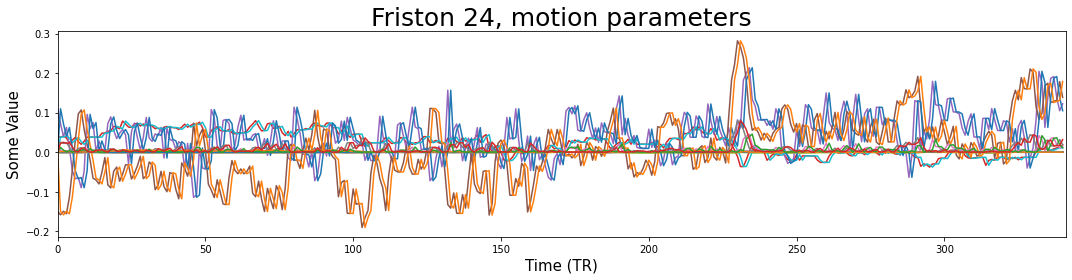

In [78]:
#We will start by taking the motion params, skipping the last value
mp_diff = motion_params[0:len(motion_params)-1, :]
#Then we insert zeros at index=0, thus shifting the values to lag-1
mp_diff = np.insert(mp_diff, 0, values=np.zeros(6), axis=0)

orig = np.hstack((motion_params, mp_diff))
squares = orig ** 2
friston24 = np.hstack((orig, squares))

plt.figure(figsize=(15, 4))

plt.title('Friston 24, motion parameters', fontsize=25)
plt.plot(friston24)
plt.xlim(0, friston24.shape[0])
plt.ylabel('Some Value', fontsize=15)
plt.xlabel('Time (TR)', fontsize=15)


plt.tight_layout()
plt.show()

Apart from directly adding the (extended) motion parameters to your design, you can also perform "motion scrubbing". Motion scrubbing is usually performed in resting-state analyses and is conceptually very similar to the "despiking" we did earlier. With motion scrubbing, you usually set a predefined threshold for your FD trace (for example 1 mm) and any timepoint above this threshold will be "scrubbed out". This is done by defining a separate regressor for each timepoint above the threshold containing all zeros except for the above-threshold timepoint, which contains a one (just like we did with despiking). Sometimes, even the timepoint before and/or after the "bad" timepoint are additionally added to the design matrix. As this course focuses mostly on task-based fMRI analyses, we won't discuss motion scrubbing any further (but if you want to know more about the different motion correction strategies, we recommend the following article: [Power et al., 2015](https://www.sciencedirect.com/science/article/pii/S1053811914008702)).

<div class='alert alert-warning'>
<b>ToDo</b> (2 points)
    
For this ToDo, you have to compare two models and the resulting (normalized) effects (t-values): a model *without* the six motion parameters and a model *with* the six motion parameters. You should use the <tt>motion_params</tt> variable which we defined earlier as your motion parameters.

We provide you with a design-matrix (<tt>X</tt>) with an intercept and a single stimulus-predictor and the signal of a single voxel (<tt>sig</tt>). Calculate the t-value for the contrast of the predictor-of-interest against baseline for both the original design-matrix (only intercept + predictor-of-interest; store this in a variable named <tt>tval_simple</tt>)
and the design-matrix extended with the six motion parameters (which thus has 8 predictors; store this in a variable named <tt>tval_ext</tt>).
</div>

In [80]:
# First, we'll load the data
with np.load('data/data_motion_filtering.npz') as data_last_todo:
    X = data_last_todo['X']
    sig = data_last_todo['sig']

print("Shape of original X: %s" % (X.shape,))
print("Shape of signal: %s" % (sig.shape,))

Shape of original X: (341, 2)
Shape of signal: (341,)


In [81]:
cvec = np.array([0, 1])
bsimple = inv(X.T @ X) @ X.T @ sig
sigma_hat = np.sum((sig - X @ bsimple) ** 2) / (X.shape[0] - X.shape[1])
desvar = cvec @ inv(X.T @ X) @ cvec.T
tval_simple = cvec @ bsimple / np.sqrt(sigma_hat * desvar)
print('t-value without including motion:', tval_simple)

X_ext = np.hstack((X, motion_params))
cvec = np.array([0, 1, 0, 0, 0, 0, 0, 0])
bext = inv(X_ext.T @ X_ext) @ X_ext.T @ sig
sigma_hat = np.sum((sig - X_ext @ bext) ** 2) / (X_ext.shape[0] - X_ext.shape[1])
desvar = cvec @ inv(X_ext.T @ X_ext) @ cvec.T
tval_ext = (cvec @ bext) / np.sqrt(sigma_hat * desvar)
print('t-value with motion modelled:', tval_ext)

X_ext2 = np.hstack((X, friston24))
cvec2 = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
bext2 = inv(X_ext2.T @ X_ext2) @ X_ext2.T @ sig
sigma_hat2 = np.sum((sig - X_ext2 @ bext2) ** 2) / (X_ext2.shape[0] - X_ext2.shape[1])
desvar2 = cvec2 @ inv(X_ext2.T @ X_ext2) @ cvec2.T
tval_ext2 = (cvec2 @ bext2) / np.sqrt(sigma_hat2 * desvar2)
print('t-value with motion modelled using Friston24:', tval_ext2)


t-value without including motion: 6.34439904416179
t-value with motion modelled: 5.209444707353544
t-value with motion modelled using Friston24: 4.658414598210267


<b>NB.</b> As, can be seen the $t$-value of the extended models (with motion parameters) are actually <em>smaller</em> than the simple model (without motion parameters) ... What caused the t-value of <em>this predictor</em> to become smaller when the motion-parameters were included in your design-matrix?

If your stimulus predictor is correlated to the model parameters, then the increased design-variance will actually lead to lower *t*-values! Note that it's not the increase in degrees of freedom that caused a smaller *t*-value, because the noise term is actually lower when the motion parameters are included!

Having motion which time-locket to the experiment is very dangerous, because you may mistake motion for brain activation linked to the experiment. By including motion parameters, we are trying to take this uncertainty into account.


Alright, that's it for preprocessing! If you want to know more about a preprocessing software package that we particularly like, check out the next (optional) notebook about [Fmriprep](https://fmriprep.readthedocs.io/) (`fmriprep.ipynb`)!

<div class='alert alert-success'>
    <b>SOLUTIONS</b>

</div>

<div class='alert alert-info'>
    <b>Solution for ToThink1</b>:
</div>

This is a bad idea because you have two opposing goals of spatial and temporal filtering: you want to high-pass the temporal dimension while low-pass the spatial dimensions. Applying a single 4D spatial (low-pass) filter will unintentionally also low-pass the temporal dimension.

<div class='alert alert-info'>
    <b>Solution for ToThink2</b>:
</div>

Shearing and scaling would change the shape and size of the brain, which we are not interested in (at this step, but see normalization).

<div class='alert alert-warning'>
    <b>Solution for ToDo1</b> :

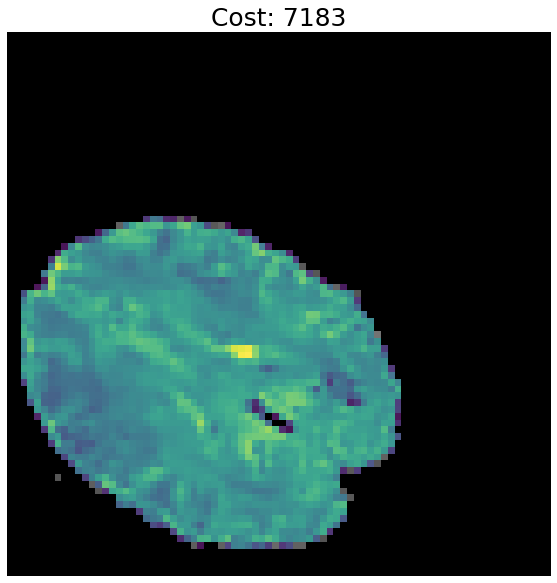

In [55]:
with np.load('data/moco_todo.npz') as moco_data:
    moving = moco_data['moving']
    fixed = moco_data['fixed']

#Work on the rotation and translation parameters
moved = resample_image(
    moving,
    rot_mat=get_rotation_matrix(0, 0, 60),
    trans_mat=get_translation_matrix(-10, -10, 0)
)
cost = least_squares_cost(fixed, moved)


### Plotting starts here

plt.figure(figsize=(10, 10))
plt.imshow(fixed[:, :, 25].T, origin='lower', cmap='gray')
moved4plot = np.ma.masked_where(moved < 2, moved)
plt.imshow(moved4plot[:, :, 25].T, origin='lower', alpha=0.8)
plt.title("Cost: %i" % cost, fontsize=(25))
plt.axis('off')
plt.show()